In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

In [4]:
data = pd.read_parquet("generated_files/bio_variables_dataframe_occurence_and_abscence.parquet").drop(columns=['Latitude','Longitude'])

In [5]:
data

,presence,01_annual_mean_temp,10_mean_temp_warmest_quarter,11_mean_temp_coldest_quarter,12_annual_precipitation,13_precipitation_wettest_month,14_precipitation_driest_month,15_precipitation_seasonality,16_precipitation_of_wettest_quarter,17_precipitation_of_driest_quarter,18_precipitation_of_warmest_quarter,19_precipitation_of_coldest_quarter,02_mean_diurnal_range,03_isothermality,04_temperature_seasonality,05_maximum_temp_warmest_month,06_minimum_temp_coldest_month,07_temp_annual_range,08_mean_temp_wettest_quarter,09_mean_temp_driest_quarter
0,1,13.945833,16.733334,10.850000,1919.0,336.0,28.0,72.874336,948.0,103.0,948.0,103.0,12.091666,60.157547,240.704056,23.000000,2.9,20.100000,16.733334,10.850000
1,1,14.158333,17.683332,10.200000,1757.0,315.0,33.0,66.050507,844.0,142.0,844.0,142.0,11.900000,51.965065,311.016174,24.900000,2.0,22.900000,17.683332,10.200000
2,1,14.158333,17.683332,10.200000,1757.0,315.0,33.0,66.050507,844.0,142.0,844.0,142.0,11.900000,51.965065,311.016174,24.900000,2.0,22.900000,17.683332,10.200000
3,1,17.004168,20.950001,13.166667,1836.0,177.0,119.0,9.750093,495.0,429.0,483.0,463.0,8.791667,50.818886,319.711914,25.799999,8.5,17.299999,14.833333,18.200001
4,1,15.404167,19.166666,11.600000,1479.0,153.0,97.0,16.505239,426.0,298.0,426.0,344.0,10.175000,54.411762,311.451599,24.700001,6.0,18.700001,19.166666,13.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3547,0,24.083334,25.133333,22.150000,790.0,178.0,1.0,96.469620,467.0,7.0,223.0,7.0,12.133333,71.372551,132.430649,31.900000,14.9,17.000000,24.883333,22.150000
3548,0,22.808332,25.866667,19.783333,2544.0,327.0,105.0,39.346584,961.0,329.0,961.0,329.0,7.616667,50.777779,246.630325,29.900000,14.9,15.000000,25.866667,19.783333
3549,0,20.720833,24.049999,16.850000,1465.0,160.0,69.0,23.872379,436.0,293.0,436.0,329.0,12.591666,61.422764,297.271362,30.500000,10.0,20.500000,24.049999,17.016666
3550,0,21.783333,23.216667,18.933332,1484.0,274.0,13.0,79.374802,743.0,45.0,609.0,64.0,12.900000,67.187500,190.779892,29.900000,10.7,19.200001,23.166666,19.200001


In [6]:
fillers = data['01_annual_mean_temp'].min()

In [7]:
data = data[data['01_annual_mean_temp'] != fillers].reset_index(drop=True)

In [6]:
cols_1 = ['01_annual_mean_temp', '10_mean_temp_warmest_quarter',
       '11_mean_temp_coldest_quarter', '12_annual_precipitation',
       '13_precipitation_wettest_month', '14_precipitation_driest_month',
       '15_precipitation_seasonality', '16_precipitation_of_wettest_quarter',
       '17_precipitation_of_driest_quarter',
       '18_precipitation_of_warmest_quarter',
       '19_precipitation_of_coldest_quarter', '02_mean_diurnal_range',
       '03_isothermality', '04_temperature_seasonality',
       '05_maximum_temp_warmest_month', '06_minimum_temp_coldest_month',
       '07_temp_annual_range', '08_mean_temp_wettest_quarter',
       '09_mean_temp_driest_quarter']

In [7]:
X = pd.DataFrame(data, columns = cols_1)
y = data['presence']

In [8]:
# ML 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import model_selection 
from sklearn import metrics
import matplotlib.pyplot as plt

In [9]:
# ML classifier dictionary: name: (model)
CLASS_MAP = {
    'RF': (RandomForestClassifier()), 
    'ET': (ExtraTreesClassifier()), 
    'ADA' : (AdaBoostClassifier()), 
    'BAG' : (BaggingClassifier()), 
    'GRA' : (GradientBoostingClassifier()), 
    'XGB': (XGBClassifier()), 
    'LGBM': (LGBMClassifier()), 
    'Maxent':(LogisticRegression(max_iter=1000)), 
    }

In [10]:
# ROC 
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [11]:
# Classifier evaluation functions (modify pyimpute function)
def evaluate_clf(
    clf, X, y, name, k=None, test_size=0.2, scoring="f1_weighted", feature_names=None
):
    print(name)
    X_train, X_test, y_train, y_true = model_selection.train_test_split(
        X, y,
        test_size=test_size, # Test data size
        shuffle=True, # Shuffle the data before split
        stratify=y # Keeping the appearance/non-appearance ratio of Y
    )

    if k: # Cross-validation
        kf = model_selection.KFold(n_splits=k) # k-fold
        scores = model_selection.cross_val_score(clf, X_train, y_train, cv=kf, scoring=scoring)
        print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
              % (k, scores.mean() * 100, scores.std() * 200))
        print()
    
    clf.fit(X_train, y_train) # Training of classifiers
    y_pred = clf.predict(X_test) # Classifier predictions
    
    # Classifier evaluation metrics
    print("Accuracy Score: %.2f" % metrics.accuracy_score(y_true, y_pred))
    print()

    print("Classification report")
    print(metrics.classification_report(y_true, y_pred))
    print()

    print("Confussion matrix")
    print(metrics.confusion_matrix(y_true, y_pred))
    print()
    
    print('AUC(ROC): %.2f'% metrics.roc_auc_score(y_true, y_pred))
    print()
       
    # ROC 
    probs = clf.predict_proba(X_test) 
    prob = probs[:, 1]  
    fper, tper, thresholds = metrics.roc_curve(y_true, prob)
    plot_roc_curve(fper, tper)

    if hasattr(clf, "feature_importances_"):
        print("Feature importances")
        for f, imp in zip(feature_names, clf.feature_importances_):
            print("%20s: %s" % (f, round(imp * 100, 1)))
        print()

In [12]:
small_columns = ['01_annual_mean_temp',
       '12_annual_precipitation',
       '04_temperature_seasonality',
       '06_minimum_temp_coldest_month',
       '07_temp_annual_range']

In [13]:
even_smaller_columns = ['01_annual_mean_temp',
       '12_annual_precipitation']

RF
RF 5-fold Cross Validation Accuracy: 94.19 (+/- 1.27)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       140
           1       0.96      0.96      0.96       570

    accuracy                           0.94       710
   macro avg       0.91      0.90      0.90       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[118  22]
 [ 21 549]]

AUC(ROC): 0.90



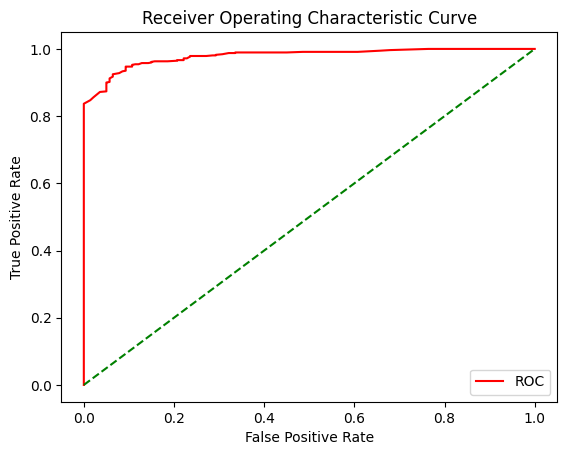

Feature importances
 01_annual_mean_temp: 9.9
10_mean_temp_warmest_quarter: 10.7
11_mean_temp_coldest_quarter: 8.1
12_annual_precipitation: 4.8
13_precipitation_wettest_month: 2.7
14_precipitation_driest_month: 2.5
15_precipitation_seasonality: 2.6
16_precipitation_of_wettest_quarter: 3.6
17_precipitation_of_driest_quarter: 3.4
18_precipitation_of_warmest_quarter: 4.3
19_precipitation_of_coldest_quarter: 3.0
02_mean_diurnal_range: 4.4
    03_isothermality: 7.2
04_temperature_seasonality: 5.5
05_maximum_temp_warmest_month: 4.3
06_minimum_temp_coldest_month: 8.5
07_temp_annual_range: 2.9
08_mean_temp_wettest_quarter: 7.2
09_mean_temp_driest_quarter: 4.3

ET
ET 5-fold Cross Validation Accuracy: 94.56 (+/- 1.97)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       140
           1       0.95      0.96      0.96       570

    accuracy                           0.93       710
   macro avg       

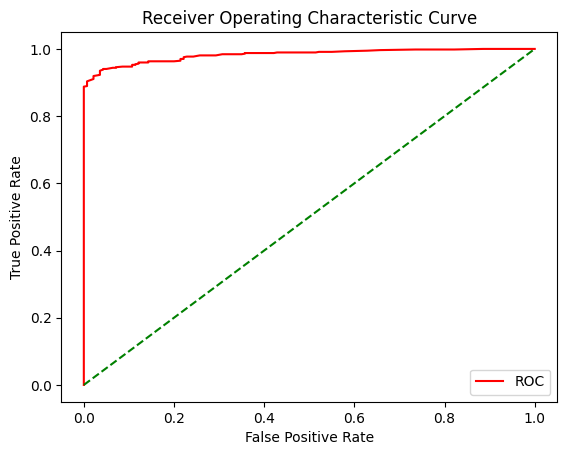

Feature importances
 01_annual_mean_temp: 8.9
10_mean_temp_warmest_quarter: 8.8
11_mean_temp_coldest_quarter: 8.3
12_annual_precipitation: 5.1
13_precipitation_wettest_month: 3.5
14_precipitation_driest_month: 4.0
15_precipitation_seasonality: 4.0
16_precipitation_of_wettest_quarter: 3.8
17_precipitation_of_driest_quarter: 3.6
18_precipitation_of_warmest_quarter: 4.5
19_precipitation_of_coldest_quarter: 4.2
02_mean_diurnal_range: 3.6
    03_isothermality: 6.4
04_temperature_seasonality: 7.7
05_maximum_temp_warmest_month: 5.3
06_minimum_temp_coldest_month: 5.1
07_temp_annual_range: 3.0
08_mean_temp_wettest_quarter: 4.9
09_mean_temp_driest_quarter: 5.4

ADA


c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scra

ADA 5-fold Cross Validation Accuracy: 91.53 (+/- 2.25)



c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       140
           1       0.93      0.98      0.95       570

    accuracy                           0.93       710
   macro avg       0.91      0.85      0.87       710
weighted avg       0.92      0.93      0.92       710


Confussion matrix
[[100  40]
 [ 13 557]]

AUC(ROC): 0.85



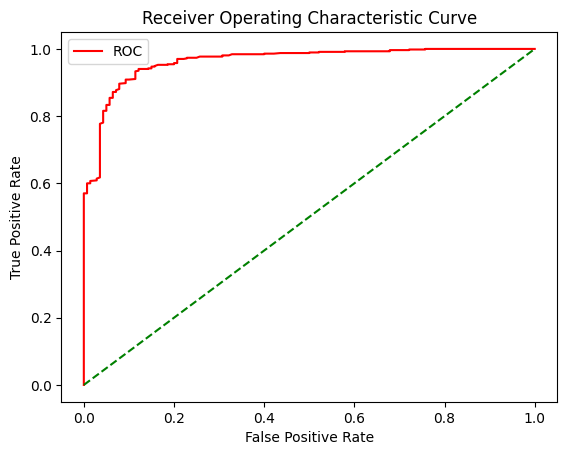

Feature importances
 01_annual_mean_temp: 4.0
10_mean_temp_warmest_quarter: 12.0
11_mean_temp_coldest_quarter: 8.0
12_annual_precipitation: 2.0
13_precipitation_wettest_month: 0.0
14_precipitation_driest_month: 2.0
15_precipitation_seasonality: 10.0
16_precipitation_of_wettest_quarter: 4.0
17_precipitation_of_driest_quarter: 4.0
18_precipitation_of_warmest_quarter: 8.0
19_precipitation_of_coldest_quarter: 8.0
02_mean_diurnal_range: 4.0
    03_isothermality: 10.0
04_temperature_seasonality: 8.0
05_maximum_temp_warmest_month: 2.0
06_minimum_temp_coldest_month: 4.0
07_temp_annual_range: 2.0
08_mean_temp_wettest_quarter: 4.0
09_mean_temp_driest_quarter: 4.0

BAG
BAG 5-fold Cross Validation Accuracy: 94.04 (+/- 0.87)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       140
           1       0.96      0.95      0.96       570

    accuracy                           0.93       710
   macro avg   

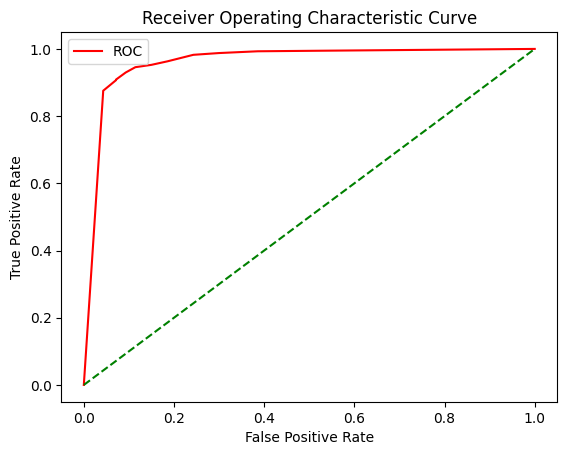

GRA
GRA 5-fold Cross Validation Accuracy: 93.08 (+/- 1.87)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       140
           1       0.95      0.96      0.96       570

    accuracy                           0.93       710
   macro avg       0.90      0.88      0.89       710
weighted avg       0.93      0.93      0.93       710


Confussion matrix
[[111  29]
 [ 20 550]]

AUC(ROC): 0.88



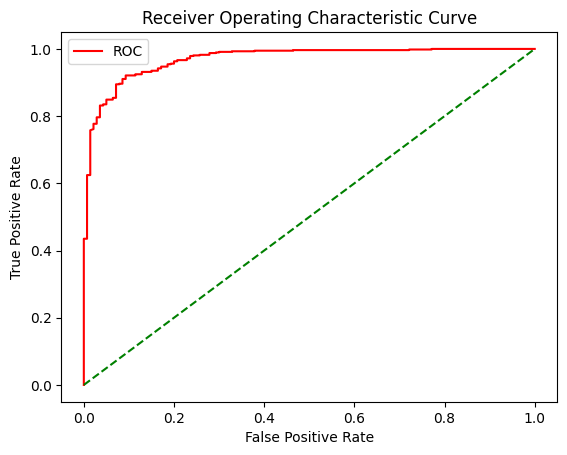

Feature importances
 01_annual_mean_temp: 32.9
10_mean_temp_warmest_quarter: 8.3
11_mean_temp_coldest_quarter: 4.1
12_annual_precipitation: 3.6
13_precipitation_wettest_month: 1.1
14_precipitation_driest_month: 0.7
15_precipitation_seasonality: 1.7
16_precipitation_of_wettest_quarter: 4.5
17_precipitation_of_driest_quarter: 0.7
18_precipitation_of_warmest_quarter: 4.9
19_precipitation_of_coldest_quarter: 2.0
02_mean_diurnal_range: 6.4
    03_isothermality: 11.1
04_temperature_seasonality: 8.1
05_maximum_temp_warmest_month: 0.3
06_minimum_temp_coldest_month: 4.5
07_temp_annual_range: 2.4
08_mean_temp_wettest_quarter: 0.9
09_mean_temp_driest_quarter: 1.8

XGB
XGB 5-fold Cross Validation Accuracy: 94.10 (+/- 2.42)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       140
           1       0.96      0.97      0.96       570

    accuracy                           0.94       710
   macro avg    

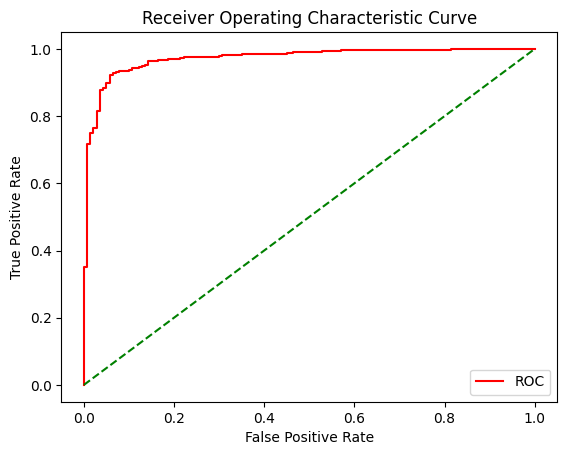

Feature importances
 01_annual_mean_temp: 30.2
10_mean_temp_warmest_quarter: 3.7
11_mean_temp_coldest_quarter: 13.6
12_annual_precipitation: 2.1
13_precipitation_wettest_month: 2.1
14_precipitation_driest_month: 1.7
15_precipitation_seasonality: 2.2
16_precipitation_of_wettest_quarter: 3.0
17_precipitation_of_driest_quarter: 2.4
18_precipitation_of_warmest_quarter: 2.9
19_precipitation_of_coldest_quarter: 5.2
02_mean_diurnal_range: 2.2
    03_isothermality: 3.9
04_temperature_seasonality: 4.2
05_maximum_temp_warmest_month: 1.2
06_minimum_temp_coldest_month: 10.5
07_temp_annual_range: 2.2
08_mean_temp_wettest_quarter: 2.0
09_mean_temp_driest_quarter: 4.7

LGBM
[LightGBM] [Info] Number of positive: 1835, number of negative: 434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4148
[Lig

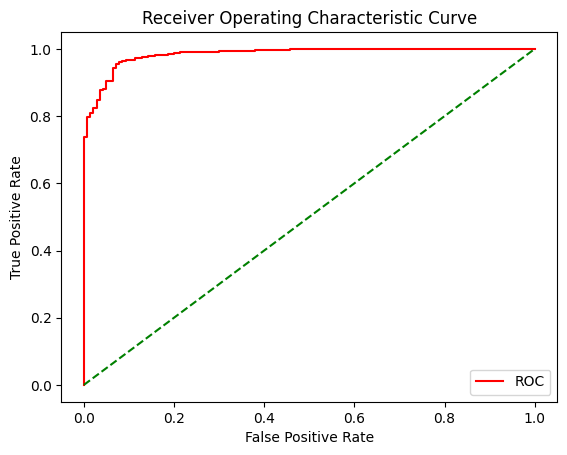

Feature importances
 01_annual_mean_temp: 13300
10_mean_temp_warmest_quarter: 13600
11_mean_temp_coldest_quarter: 13200
12_annual_precipitation: 14500
13_precipitation_wettest_month: 13400
14_precipitation_driest_month: 14200
15_precipitation_seasonality: 17000
16_precipitation_of_wettest_quarter: 12100
17_precipitation_of_driest_quarter: 11000
18_precipitation_of_warmest_quarter: 21000
19_precipitation_of_coldest_quarter: 13400
02_mean_diurnal_range: 25800
    03_isothermality: 28900
04_temperature_seasonality: 22700
05_maximum_temp_warmest_month: 10100
06_minimum_temp_coldest_month: 12000
07_temp_annual_range: 13100
08_mean_temp_wettest_quarter: 16100
09_mean_temp_driest_quarter: 14600

Maxent


c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Maxent 5-fold Cross Validation Accuracy: 87.94 (+/- 2.36)

Accuracy Score: 0.89

Classification report
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       140
           1       0.91      0.95      0.93       570

    accuracy                           0.89       710
   macro avg       0.84      0.79      0.81       710
weighted avg       0.88      0.89      0.88       710


Confussion matrix
[[ 88  52]
 [ 27 543]]

AUC(ROC): 0.79



c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


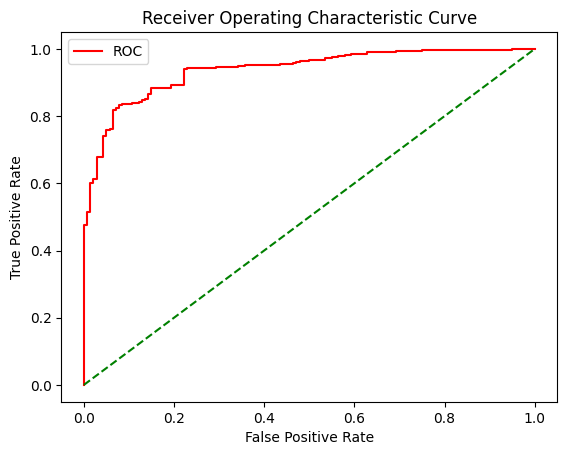

In [14]:
# Spatial prediction
for name, model in CLASS_MAP.items():
    evaluate_clf(model, X, y, name, k=5, test_size=0.2, scoring="f1_weighted", feature_names=X.columns)
    try:
        os.mkdir('OUTPUT/' + name + '-IMAGES')        
    except:
        pass    
    pyimpute.impute(target_xs, model, raster_info, outdir='OUTPUT/' + name + '-IMAGES', class_prob=True, certainty=True)


RF
RF 5-fold Cross Validation Accuracy: 94.64 (+/- 2.86)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       140
           1       0.96      0.97      0.96       570

    accuracy                           0.94       710
   macro avg       0.91      0.89      0.90       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[115  25]
 [ 19 551]]

AUC(ROC): 0.89



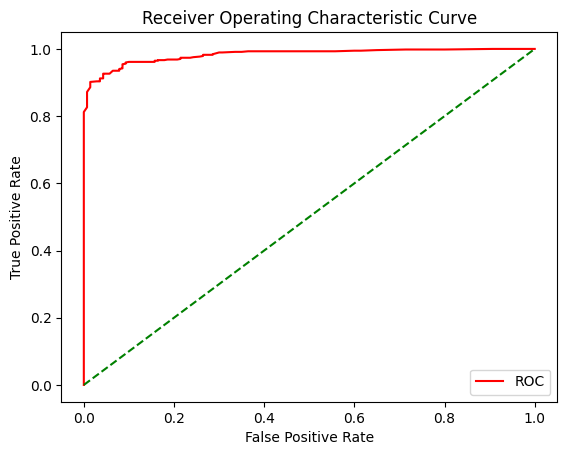

Feature importances
 01_annual_mean_temp: 13.2
12_annual_precipitation: 17.3

ET
ET 5-fold Cross Validation Accuracy: 94.85 (+/- 1.33)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       140
           1       0.96      0.97      0.96       570

    accuracy                           0.94       710
   macro avg       0.92      0.90      0.91       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[115  25]
 [ 16 554]]

AUC(ROC): 0.90



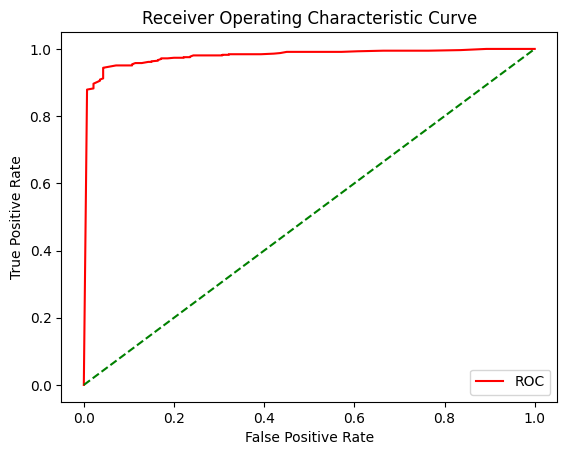

Feature importances
 01_annual_mean_temp: 7.2
12_annual_precipitation: 8.7

ADA


c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scra

ADA 5-fold Cross Validation Accuracy: 92.83 (+/- 4.18)



c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score: 0.92

Classification report
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       140
           1       0.93      0.97      0.95       570

    accuracy                           0.92       710
   macro avg       0.89      0.84      0.86       710
weighted avg       0.92      0.92      0.92       710


Confussion matrix
[[101  39]
 [ 19 551]]

AUC(ROC): 0.84



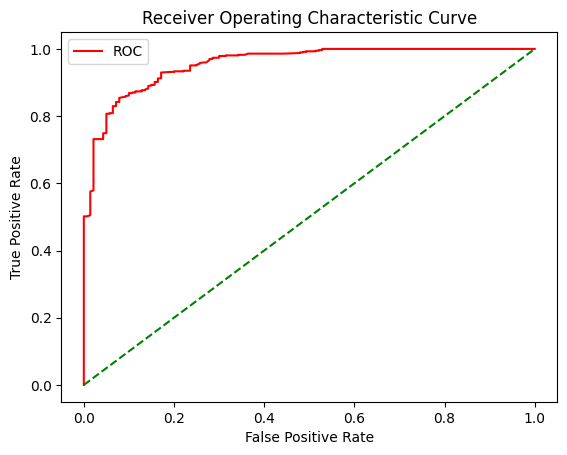

Feature importances
 01_annual_mean_temp: 10.0
12_annual_precipitation: 6.0

BAG
BAG 5-fold Cross Validation Accuracy: 93.13 (+/- 1.26)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       140
           1       0.97      0.96      0.96       570

    accuracy                           0.94       710
   macro avg       0.90      0.92      0.91       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[123  17]
 [ 24 546]]

AUC(ROC): 0.92



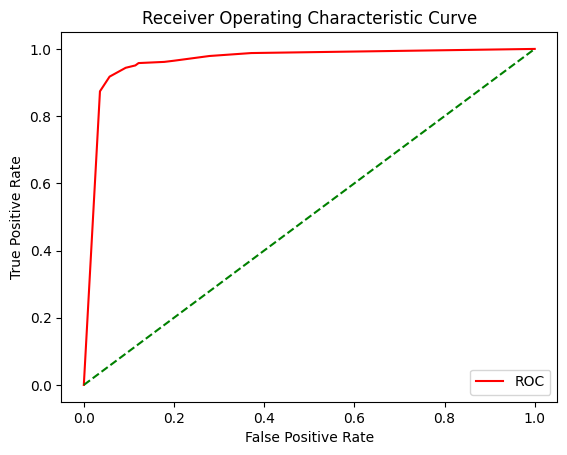

GRA
GRA 5-fold Cross Validation Accuracy: 93.58 (+/- 2.91)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       140
           1       0.95      0.97      0.96       570

    accuracy                           0.94       710
   macro avg       0.91      0.89      0.90       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[113  27]
 [ 16 554]]

AUC(ROC): 0.89



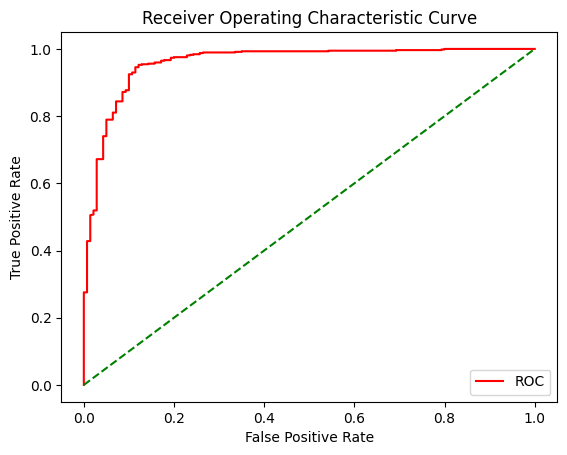

Feature importances
 01_annual_mean_temp: 4.0
12_annual_precipitation: 39.7

XGB
XGB 5-fold Cross Validation Accuracy: 93.81 (+/- 2.50)

Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       140
           1       0.95      0.96      0.96       570

    accuracy                           0.93       710
   macro avg       0.90      0.88      0.89       710
weighted avg       0.93      0.93      0.93       710


Confussion matrix
[[111  29]
 [ 20 550]]

AUC(ROC): 0.88



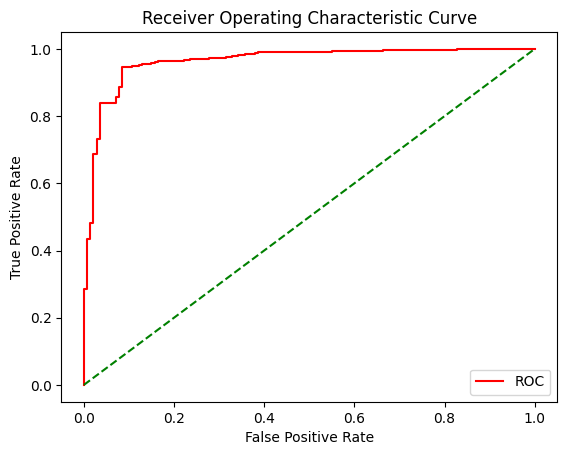

Feature importances
 01_annual_mean_temp: 19.0
12_annual_precipitation: 23.1

LGBM
[LightGBM] [Info] Number of positive: 1840, number of negative: 429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4133
[LightGBM] [Info] Number of data points in the train set: 2269, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810930 -> initscore=1.456064
[LightGBM] [Info] Start training from score 1.456064
[LightGBM] [Info] Number of positive: 1826, number of negative: 443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 2269, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.804760 -> initscore=1.4

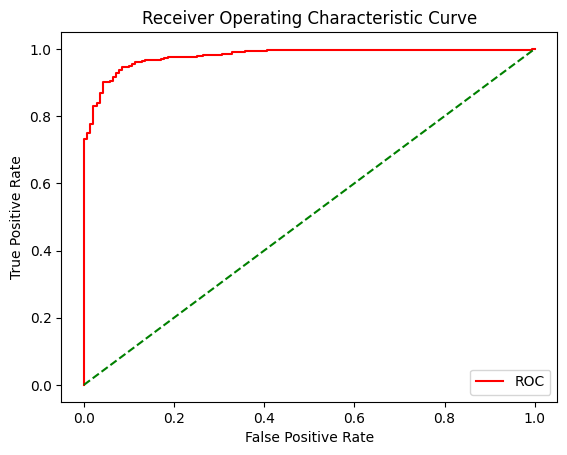

Feature importances
 01_annual_mean_temp: 12900
12_annual_precipitation: 11300

Maxent


c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Maxent 5-fold Cross Validation Accuracy: 87.90 (+/- 4.65)

Accuracy Score: 0.90

Classification report
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       140
           1       0.91      0.96      0.94       570

    accuracy                           0.90       710
   macro avg       0.86      0.79      0.82       710
weighted avg       0.89      0.90      0.89       710


Confussion matrix
[[ 87  53]
 [ 20 550]]

AUC(ROC): 0.79



c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


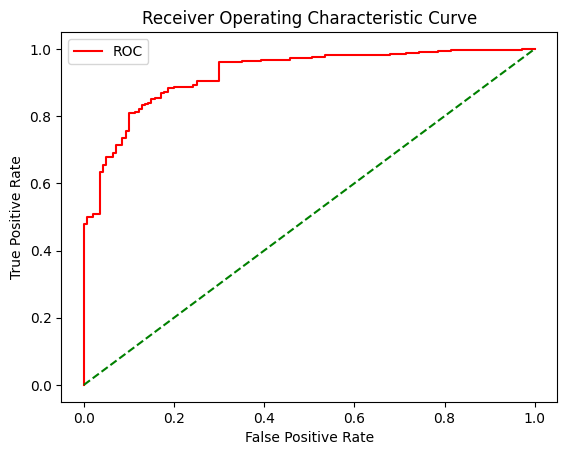

In [15]:
# Spatial prediction
for name, model in CLASS_MAP.items():
    evaluate_clf(model, X, y, name, k=5, test_size=0.2, scoring="f1_weighted", feature_names=even_smaller_columns)

RF
RF 10-fold Cross Validation Accuracy: 93.90 (+/- 2.64)

Accuracy Score: 0.96

Classification report
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       140
           1       0.97      0.98      0.97       570

    accuracy                           0.96       710
   macro avg       0.95      0.92      0.93       710
weighted avg       0.96      0.96      0.96       710


Confussion matrix
[[120  20]
 [  9 561]]

AUC(ROC): 0.92



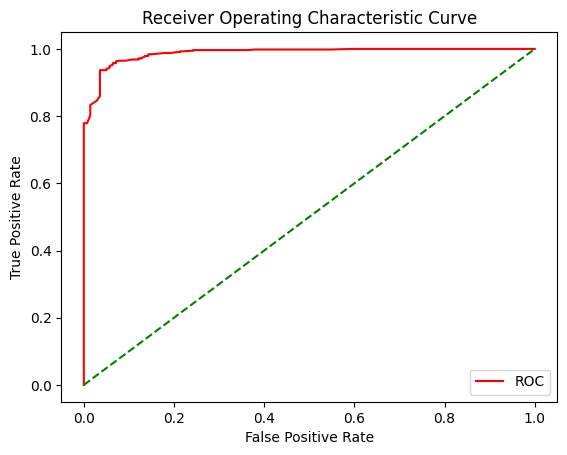

Feature importances
 01_annual_mean_temp: 9.7
12_annual_precipitation: 12.0
04_temperature_seasonality: 6.6
06_minimum_temp_coldest_month: 4.9
07_temp_annual_range: 3.0

ET
ET 10-fold Cross Validation Accuracy: 94.62 (+/- 2.00)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       140
           1       0.95      0.97      0.96       570

    accuracy                           0.94       710
   macro avg       0.91      0.88      0.89       710
weighted avg       0.93      0.94      0.93       710


Confussion matrix
[[112  28]
 [ 18 552]]

AUC(ROC): 0.88



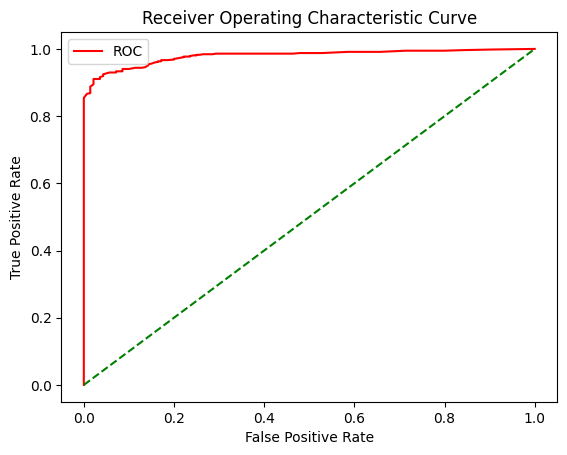

Feature importances
 01_annual_mean_temp: 7.7
12_annual_precipitation: 8.2
04_temperature_seasonality: 8.2
06_minimum_temp_coldest_month: 4.6
07_temp_annual_range: 3.5

ADA


c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scra

ADA 10-fold Cross Validation Accuracy: 92.15 (+/- 2.57)



c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score: 0.93

Classification report
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       140
           1       0.94      0.97      0.95       570

    accuracy                           0.93       710
   macro avg       0.90      0.85      0.87       710
weighted avg       0.92      0.93      0.92       710


Confussion matrix
[[103  37]
 [ 16 554]]

AUC(ROC): 0.85



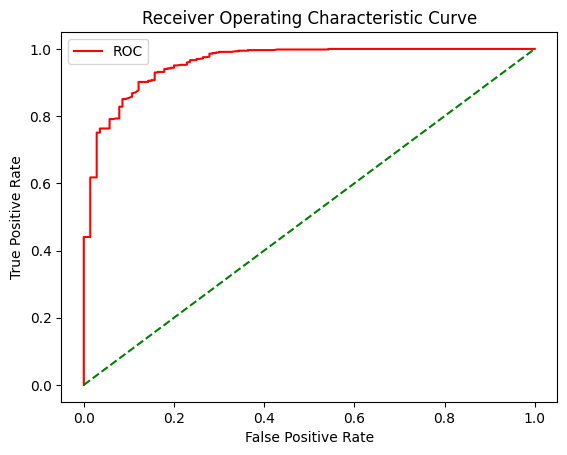

Feature importances
 01_annual_mean_temp: 6.0
12_annual_precipitation: 4.0
04_temperature_seasonality: 8.0
06_minimum_temp_coldest_month: 0.0
07_temp_annual_range: 2.0

BAG
BAG 10-fold Cross Validation Accuracy: 93.89 (+/- 3.38)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       140
           1       0.97      0.95      0.96       570

    accuracy                           0.94       710
   macro avg       0.89      0.91      0.90       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[122  18]
 [ 27 543]]

AUC(ROC): 0.91



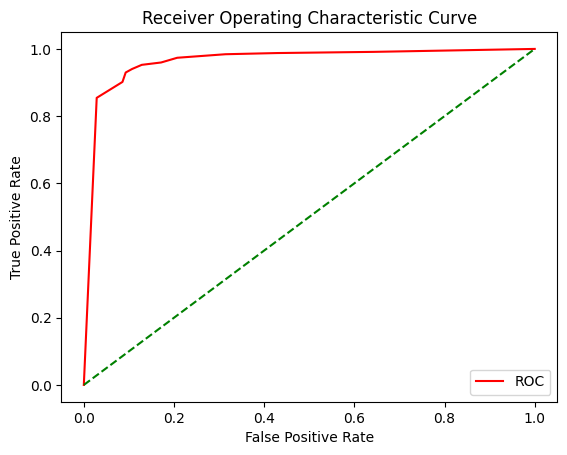

GRA
GRA 10-fold Cross Validation Accuracy: 93.01 (+/- 3.21)

Accuracy Score: 0.94

Classification report
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       140
           1       0.95      0.98      0.96       570

    accuracy                           0.94       710
   macro avg       0.93      0.88      0.90       710
weighted avg       0.94      0.94      0.94       710


Confussion matrix
[[108  32]
 [ 10 560]]

AUC(ROC): 0.88



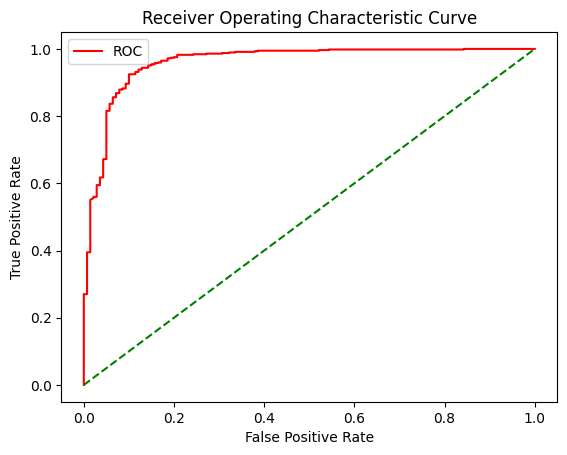

Feature importances
 01_annual_mean_temp: 27.1
12_annual_precipitation: 17.2
04_temperature_seasonality: 3.7
06_minimum_temp_coldest_month: 4.1
07_temp_annual_range: 1.3

XGB
XGB 10-fold Cross Validation Accuracy: 93.55 (+/- 3.15)

Accuracy Score: 0.95

Classification report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       140
           1       0.96      0.98      0.97       570

    accuracy                           0.95       710
   macro avg       0.94      0.90      0.92       710
weighted avg       0.95      0.95      0.95       710


Confussion matrix
[[115  25]
 [ 10 560]]

AUC(ROC): 0.90



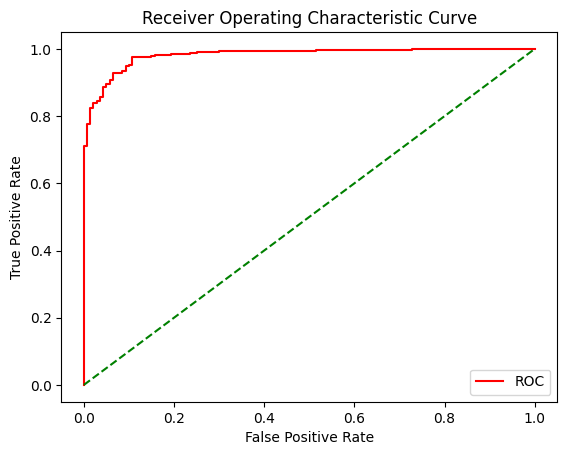

Feature importances
 01_annual_mean_temp: 38.7
12_annual_precipitation: 5.0
04_temperature_seasonality: 7.8
06_minimum_temp_coldest_month: 3.3
07_temp_annual_range: 1.6

LGBM
[LightGBM] [Info] Number of positive: 2038, number of negative: 515
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4168
[LightGBM] [Info] Number of data points in the train set: 2553, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798277 -> initscore=1.375557
[LightGBM] [Info] Start training from score 1.375557
[LightGBM] [Info] Number of positive: 2049, number of negative: 504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4154
[LightGBM] [Info] Number of data points in the train set: 2553, number of

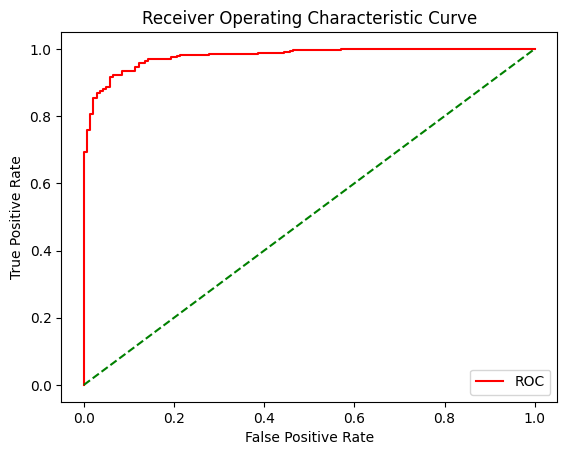

Feature importances
 01_annual_mean_temp: 14600
12_annual_precipitation: 12600
04_temperature_seasonality: 12300
06_minimum_temp_coldest_month: 15000
07_temp_annual_range: 11300

Maxent


c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

Maxent 10-fold Cross Validation Accuracy: 88.06 (+/- 4.30)

Accuracy Score: 0.89

Classification report
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       140
           1       0.91      0.96      0.93       570

    accuracy                           0.89       710
   macro avg       0.84      0.78      0.81       710
weighted avg       0.88      0.89      0.88       710


Confussion matrix
[[ 85  55]
 [ 25 545]]

AUC(ROC): 0.78



c:\Users\kenji\dev\web-scraping-images-vinacea\web-scraping-images-vinacea\web-scraping-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


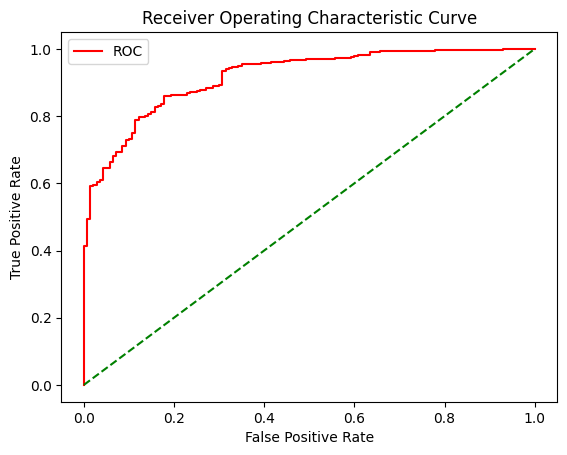

In [16]:
# Spatial prediction
for name, model in CLASS_MAP.items():
    evaluate_clf(model, X, y, name, k=10, test_size=0.2, scoring="f1_weighted", feature_names=small_columns)



In [ ]:
def plotit(x, title, cmap="Blues"):
    plt.figure(figsize = (14,7))
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')